In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.inspection import PartialDependenceDisplay
import eli5
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(63000, 182)

In [4]:
test.shape

(7000, 182)

## Baseline

In [5]:
train.isna().any().any()

False

In [6]:
test.isna().any().any()

False

In [7]:
[k for (k,v) in train.dtypes.to_dict().items() if v == 'O']

['blueTopChampionName',
 'blueJungleChampionName',
 'blueMiddleChampionName',
 'blueBottomChampionName',
 'blueUtilityChampionName',
 'redTopChampionName',
 'redJungleChampionName',
 'redMiddleChampionName',
 'redBottomChampionName',
 'redUtilityChampionName',
 'FirstBloodKiller',
 'FirstBloodVictim']

In [8]:
teams = ['blue', 'red']
positions = ['Top', 'Jungle', 'Middle', 'Bottom', 'Utility']

for data in [train, test]:
    data.drop(['FirstBloodKiller', 'FirstBloodVictim'], axis=1, inplace=True)
    data.drop([f'{team}{pos}ChampionName' for team in teams for pos in positions], axis=1, inplace=True)

In [9]:
y_train = train['blueWin'].to_numpy()
train.drop('blueWin', axis=1, inplace=True)

y_test = test['blueWin'].to_numpy()
test.drop('blueWin', axis=1, inplace=True)

In [10]:
scaler = StandardScaler().fit(train)

In [11]:
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 12.44 Mb (84.7% reduction)
Mem. usage decreased to  1.40 Mb (84.5% reduction)


In [14]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [15]:
def train_model(X_train, y_train, model, folds=folds, verbose=1, predict=False, X_test=None):
    
    if predict:
        prediction = np.zeros(len(X_test))
        
    scores_train = []
    scores_valid = []
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
        start_time = time.time()
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_train = model.predict(X_train_fold).reshape(-1,)
        train_score = accuracy_score(y_train_fold, y_pred_train)
        scores_train.append(train_score)
        
        y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
        valid_score = accuracy_score(y_valid_fold, y_pred_valid)
        scores_valid.append(valid_score)

        if predict:
            y_pred = model.predict_proba(X_test)[:, 1]
            prediction += y_pred
            
        if verbose >= 2:
            print(f'Fold {fold_n} train completed. Score:{valid_score:.4f} Time elapsed: {time.time()-start_time:.2f} sec')
            
        
    if predict:
        prediction /= folds.get_n_splits()
        
    if verbose >= 1:
        print(f'Mean train accuracy: {np.mean(scores_train):.4f}, std: {np.std(scores_train):.4f}.')
        print(f'Mean valid accuracy: {np.mean(scores_valid):.4f}, std: {np.std(scores_valid):.4f}.')

    
    return (np.mean(scores_valid), prediction) if predict else np.mean(scores_valid)

KNN, SVC, Gradient Boosting Classifier 등도 사용해 보았으나 다른 모델들에 비해 training에 과도한 시간을 소모하여 제외하였다.

In [16]:
models = {
    'Random Forest':RandomForestClassifier(n_jobs=-1), 
    'Logistic Regression':LogisticRegression(n_jobs=-1), 
    'XGBoost':XGBClassifier(eval_metric='logloss', n_jobs=-1),
    'LightGBM':LGBMClassifier(n_jobs=-1), 
    'Extra Trees':ExtraTreesClassifier(n_jobs=-1), 
    'AdaBoost':AdaBoostClassifier(),
    'Bagging Classifier':BaggingClassifier(n_jobs=-1),
    'Gaussian Naive Bayes':GaussianNB()
}

In [17]:
baseline_results = {
    'model':[],
    'time_spent':[],
    'mean_valid_accuracy':[]
}

for name, model in models.items():
    baseline_results['model'].append(name)
    print(name)
    
    start_time = time.time()
    acc = train_model(X_train, y_train, model=model)
    end_time = time.time()
    
    baseline_results['mean_valid_accuracy'].append(acc)
    baseline_results['time_spent'].append(end_time-start_time)
    
    print(f'Time Spent: {end_time-start_time:.3f} sec')
    print('')

baseline_results = pd.DataFrame(baseline_results).sort_values('mean_valid_accuracy', ascending=False)

Random Forest
Mean train accuracy: 1.0000, std: 0.0000.
Mean valid accuracy: 0.7868, std: 0.0038.
Time Spent: 81.580 sec

Logistic Regression
Mean train accuracy: 0.7957, std: 0.0007.
Mean valid accuracy: 0.7943, std: 0.0044.
Time Spent: 199.873 sec

XGBoost
Mean train accuracy: 0.8792, std: 0.0015.
Mean valid accuracy: 0.7819, std: 0.0054.
Time Spent: 131.174 sec

LightGBM
Mean train accuracy: 0.8235, std: 0.0005.
Mean valid accuracy: 0.7894, std: 0.0042.
Time Spent: 22.615 sec

Extra Trees
Mean train accuracy: 1.0000, std: 0.0000.
Mean valid accuracy: 0.7829, std: 0.0038.
Time Spent: 62.767 sec

AdaBoost
Mean train accuracy: 0.7807, std: 0.0005.
Mean valid accuracy: 0.7784, std: 0.0034.
Time Spent: 232.751 sec

Bagging Classifier
Mean train accuracy: 0.9878, std: 0.0005.
Mean valid accuracy: 0.7556, std: 0.0053.
Time Spent: 156.104 sec

Gaussian Naive Bayes
Mean train accuracy: 0.7807, std: 0.0006.
Mean valid accuracy: 0.7802, std: 0.0044.
Time Spent: 4.224 sec



In [18]:
baseline_results

,model,time_spent,mean_valid_accuracy
1,Logistic Regression,199.872734,0.794302
3,LightGBM,22.615420,0.789381
0,Random Forest,81.579647,0.786762
4,Extra Trees,62.766943,0.782889
2,XGBoost,131.174336,0.781873
7,Gaussian Naive Bayes,4.223735,0.780190
5,AdaBoost,232.750723,0.778444
6,Bagging Classifier,156.103979,0.755635


추가적인 feature selection 및 hyperparameter tuning을 진행하지 않은 상태로 학습을 진행한 결과, valid set에서 최대 0.7943의 mean accuracy를 기록했다.

### Feature Selection

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [20]:
teams = ['blue', 'red']
positions = ['Top', 'Jungle', 'Middle', 'Bottom', 'Utility']
locations = ['Outer', 'Inner', 'Base']
buildings = [loc +'Turret' for loc in locations] + ['Inhibitor', 'NexusTurret']
lanes = ['Top', 'Mid', 'Bot']
dragons = ['Air', 'Earth', 'Fire', 'Hextech', 'Water']
win = [True, False]

In [21]:
def search(*args, data=train):
    cmd = []

    for arg in args:
        arg = arg.split('|') if '|' in arg else arg

        if type(arg) == str:
            cmd.append(f'("{arg[arg[0]=="~":]}" {"not " if arg[0] == "~" else ""}in col)')

        else:
            concat = ' | '.join(f'("{word[word[0]=="~":]}" {"not " if word[0] == "~" else ""}in col)' for word in arg)
            cmd.append(f'({concat})')
    

    return [col for col in data.columns if eval(' & '.join(cmd))]

#### Building

In [22]:
for data in [train, test]:
    for team in teams:
        for loc in locations:
            data[f'{team}{loc}TurretLost'] = data[[f'{team}{loc}{lane}TurretLost' for lane in lanes]].sum(axis=1)


    for loc in locations[:-1]:
        data[f'blue{loc}TurretDiff'] = data[f'red{loc}TurretLost'] - data[f'blue{loc}TurretLost']
        
        
    for lane in lanes:
        data[f'blueOuter{lane}TurretDiff'] = data[f'redOuter{lane}TurretLost'] - data[f'blueOuter{lane}TurretLost']
#        data[f'blue{lane}TurretDiff'] = data[[f'red{loc}{lane}TurretLost' for loc in locations]].sum(axis=1) - data[[f'blue{loc}{lane}TurretLost' for loc in locations]].sum(axis=1)


    data[f'blueInnerBuildingDiff'] = data[[f'red{building}Lost' for building in buildings[-2:]]].sum(axis=1) - data[[f'blue{building}Lost' for building in buildings[-2:]]].sum(axis=1)
    
    
    for team in teams:
        data[f'{team}TotalBuildingLost'] = data[[f'{team}{building}Lost' for building in buildings]].sum(axis=1)


    data['blueTotalBuildingDiff'] = data[[f'red{building}Lost' for building in buildings]].sum(axis=1) - data[[f'blue{building}Lost' for building in buildings]].sum(axis=1)

    data.drop([f'{team}{building}Lost' for team in teams for building in buildings], axis=1, inplace=True)
    data.drop([f'{team}{loc}{lane}TurretLost' for team in teams for loc in locations for lane in lanes], axis=1, inplace=True)
    data.drop([f'{team}TotalBuildingLost' for team in teams], axis=1, inplace=True)

In [23]:
search('Building|Turret|Inhibitor')

['blueOuterTurretDiff',
 'blueInnerTurretDiff',
 'blueOuterTopTurretDiff',
 'blueOuterMidTurretDiff',
 'blueOuterBotTurretDiff',
 'blueInnerBuildingDiff',
 'blueTotalBuildingDiff']

`blueOuterTurretDiff`: 블루팀이 파괴한 1차 포탑 - 레드팀이 파괴한 1차 포탑

`blueInnerTurretDiff`: 블루팀이 파괴한 2차 포탑 - 레드팀이 파괴한 2차 포탑

`blueInnerBuildingDiff`: (블루팀이 파괴한 억제기 포탑 + 억제기 + 넥서스 포탑) - (레드팀이 파괴한 억제기 포탑 + 억제기 + 넥서스 포탑)

`blueOuterTopTurretDiff`: 블루팀이 파괴한 1차 탑 라인 포탑 - 레드팀이 파괴한 1차 탑 라인 포탑

`blueOuterMidTurretDiff`: 블루팀이 파괴한 1차 미드 라인 포탑 - 레드팀이 파괴한 1차 미드 라인 포탑

`blueOuterBotTurretDiff`: 블루팀이 파괴한 1차 바텀 라인 포탑 - 레드팀이 파괴한 1차 바텀 라인 포탑

`blueTotalBuildingDiff` : 블루팀이 파괴한 전체 건물 수 - 레드팀이 파괴한 전체 건물 수

#### Ace, Dragon, Herald

In [24]:
for data in [train, test]:
    for obj in ['Ace', 'Herald', 'TotalDragon']:
        data[f'blue{obj}KillDiff'] = data[f'blue{obj}Kill'] - data[f'red{obj}Kill']
        data.drop([f'blue{obj}Kill', f'red{obj}Kill'], axis=1, inplace=True)
        
    for dragon in dragons:
        data.drop([f'blue{dragon}DragonKill', f'red{dragon}DragonKill'], axis=1, inplace=True)        

In [25]:
search('Herald|Dragon|Ace')

['blueAceKillDiff', 'blueHeraldKillDiff', 'blueTotalDragonKillDiff']

`blueAceKillDiff`: 블루팀이 기록한 에이스 - 레드팀이 기록한 에이스

`blueHeraldKillDiff`: 블루팀이 처치한 전령 - 레드팀이 처치한 전령

`blueTotalDragonKillDiff`: 블루팀이 처치한 드래곤 - 레드팀이 처치한 드래곤

#### CS

In [26]:
for data in [train, test]:
    for team in teams:
        for pos in positions:
            data[f'{team}{pos}CS'] = data[f'{team}{pos}MinionsKilled'] + data[f'{team}{pos}JungleMinionsKilled']
            data.drop([f'{team}{pos}MinionsKilled', f'{team}{pos}JungleMinionsKilled'], axis=1, inplace=True)

        data[f'{team}TotalCS'] = data[[f'{team}{pos}CS' for pos in positions]].sum(axis=1)
        
        
    for pos in positions:
        data[f'blue{pos}CSDiff'] = data[f'blue{pos}CS'] - data[f'red{pos}CS']      


    data['blueTotalCSDiff'] = data['blueTotalCS'] - data['redTotalCS']
    data.drop([f'{team}{pos}CS' for team in teams for pos in positions], axis=1, inplace=True) #
    data.drop([f'{team}TotalCS' for team in teams], axis=1, inplace=True)
    #data.drop([f'{team}UtilityCS' for team in teams], axis=1, inplace=True) #

In [27]:
search('CS')

['blueTopCSDiff',
 'blueJungleCSDiff',
 'blueMiddleCSDiff',
 'blueBottomCSDiff',
 'blueUtilityCSDiff',
 'blueTotalCSDiff']

`blue{position}CSDiff`: 블루팀 해당 포지션이 획득한 CS - 레드팀 해당 포지션이 획득한 CS

`blueTotalCSDiff`: 블루팀 전체 CS - 레드팀 전체 CS

#### Gold

In [28]:
for data in [train, test]:
    
    for team in teams:
        data[f'{team}TotalGold'] = data[[f'{team}{pos}TotalGold' for pos in positions]].sum(axis=1)
        
#        for pos in positions:
#            data[f'{team}{pos}GoldProportion'] = data[f'{team}{pos}TotalGold'] / data[f'{team}TotalGold']
        
#        data[f'{team}GoldProportionStd'] = data[[f'{team}{pos}GoldProportion' for pos in positions]].std(axis=1)

    data['blueTotalGoldDiff'] = data['blueTotalGold'] - data['redTotalGold']
    data.drop(['blueTotalGold', 'redTotalGold'], axis=1, inplace=True)
    
    
    for pos in positions:
        data[f'blue{pos}GoldDiff'] = data[f'blue{pos}TotalGold'] - data[f'red{pos}TotalGold']
        
    
#    for team in teams:
#        goldmax, goldmin = [], []
#        
#        for k, v in data[[f'{team}{pos}TotalGold' for pos in positions]].T.to_dict().items():
#            col = sorted(v.items(), key=lambda x: x[1])
#            goldmax.append(col[-1][0][3+(team=='blue'):-9])
#            goldmin.append(col[0][0][3+(team=='blue'):-9])

#        data[f'{team}GoldMaxIsUtility'] = (pd.DataFrame(goldmax) == 'Utility')
#        data[f'{team}GoldMinIsBottom'] = (pd.DataFrame(goldmin) == 'Bottom')
        
    data.drop([f'{team}{pos}TotalGold' for team in teams for pos in positions], axis=1, inplace=True) #

In [29]:
search('Gold')

['blueTotalGoldDiff',
 'blueTopGoldDiff',
 'blueJungleGoldDiff',
 'blueMiddleGoldDiff',
 'blueBottomGoldDiff',
 'blueUtilityGoldDiff']

`blue{position}GoldDiff`: 블루팀 해당 포지션이 획득한 골드 - 레드팀 해당 포지션이 획득한 골드

`blueTotalGoldDiff`: 블루팀 전체 획득 골드 - 레드팀 전체 획득 골드

#### KDA

In [30]:
for data in [train, test]:
    for team in teams:
        data[f'{team}KDA3'] = data[[f'{team}{pos}Kill' for pos in positions]].sum(axis=1) + data[[f'{team}{pos}Assist' for pos in positions]].sum(axis=1) - data[[f'{team}{pos}Death' for pos in positions]].sum(axis=1) * 1.5
        
        for pos in positions:
            data[f'{team}{pos}KDA3'] = (data[f'{team}{pos}Kill'] + data[f'{team}{pos}Assist']) - data[f'{team}{pos}Death'] * 1.5
    
    data.drop([f'{team}{pos}Kill' for team in teams for pos in positions], axis=1, inplace=True) #
    data.drop([f'{team}{pos}Death' for team in teams for pos in positions], axis=1, inplace=True) #
    data.drop([f'{team}{pos}Assist' for team in teams for pos in positions], axis=1, inplace=True) #
    data.drop([f'{team}{pos}SoloKill' for team in teams for pos in positions], axis=1, inplace=True)
    data.drop([f'{team}{pos}SoloKillVictim' for team in teams for pos in positions], axis=1, inplace=True)

In [31]:
search('Kill|Death|Assist|KDA', '~Dragon', '~Ward', '~Herald', '~Ace', '~Killer')

['blueFirstBloodKill',
 'blueKDA3',
 'blueTopKDA3',
 'blueJungleKDA3',
 'blueMiddleKDA3',
 'blueBottomKDA3',
 'blueUtilityKDA3',
 'redKDA3',
 'redTopKDA3',
 'redJungleKDA3',
 'redMiddleKDA3',
 'redBottomKDA3',
 'redUtilityKDA3']

`blueFirstBloodKill`: 블루팀의 퍼스트 블러드 획득 여부

`{team}KDA3`: 해당 팀 전체 킬 + 어시스트 - 1.5 * 데스

`{team}{position}KDA3`: 해당 팀 해당 포지션의 킬 + 어시스트 - 1.5 * 데스

#### Level

In [32]:
for data in [train, test]:
    for pos in positions:
        data[f'blue{pos}LevelDiff'] = data[f'blue{pos}Level'] - data[f'red{pos}Level']
    for team in teams:
        data[f'{team}TotalLevel'] = data[[f'{team}{pos}Level' for pos in positions]].sum(axis=1)

    data['blueTotalLevelDiff'] = data['blueTotalLevel'] - data['redTotalLevel']
    data.drop([f'{team}{pos}Level' for team in teams for pos in positions], axis=1, inplace=True) #
    data.drop(['blueTotalLevel', 'redTotalLevel'], axis=1, inplace=True)

In [33]:
search('Level')

['blueTopLevelDiff',
 'blueJungleLevelDiff',
 'blueMiddleLevelDiff',
 'blueBottomLevelDiff',
 'blueUtilityLevelDiff',
 'blueTotalLevelDiff']

`blue{position}LevelDiff`: 블루팀 해당 포지션의 레벨 - 레드팀 해당 포지션의 레벨

`blueTotalLevelDiff`: 블루팀 전체 레벨 합 - 레드팀 전체 레벨 합

#### Damage

In [34]:
for data in [train, test]:
    data['blueTotalDamageDoneDiff'] = data[[f'blue{pos}TotalDamageDoneToChampions' for pos in positions]].sum(axis=1) - data[[f'red{pos}TotalDamageDoneToChampions' for pos in positions]].sum(axis=1)
    data['blueTotalDamageTakenDiff'] = data[[f'blue{pos}TotalDamageTaken' for pos in positions]].sum(axis=1) - data[[f'red{pos}TotalDamageTaken' for pos in positions]].sum(axis=1)
    
    for team in teams:
        for pos in positions:
            data[f'{team}{pos}TotalDamageDiff'] = data[f'{team}{pos}TotalDamageDoneToChampions'] - data[f'{team}{pos}TotalDamageTaken']
    
    data.drop(
        [f'{team}{pos}{kind}' for team in teams for pos in ['Top', 'Jungle', 'Middle', 'Utility'] for kind in ['TotalDamageDoneToChampions', 'TotalDamageTaken']], 
        axis=1, inplace=True
    ) #

In [35]:
search('Damage')

['blueBottomTotalDamageDoneToChampions',
 'blueBottomTotalDamageTaken',
 'redBottomTotalDamageDoneToChampions',
 'redBottomTotalDamageTaken',
 'blueTotalDamageDoneDiff',
 'blueTotalDamageTakenDiff',
 'blueTopTotalDamageDiff',
 'blueJungleTotalDamageDiff',
 'blueMiddleTotalDamageDiff',
 'blueBottomTotalDamageDiff',
 'blueUtilityTotalDamageDiff',
 'redTopTotalDamageDiff',
 'redJungleTotalDamageDiff',
 'redMiddleTotalDamageDiff',
 'redBottomTotalDamageDiff',
 'redUtilityTotalDamageDiff']

`{team}BottomTotalDamageDoneToChampions`: 해당 팀 원딜 포지션이 챔피언에게 가한 데미지

`{team}BottomTotalDamageTaken`: 해당 팀 원딜 포지션이 받은 데미지

`blue{position}DamageDoneDiff`: 블루팀 해당 포지션이 챔피언에게 가한 데미지 - 레드팀 해당 포지션이 챔피언에게 가한 데미지

`blue{position}DamageTakenDiff`: 블루팀 해당 포지션이 받은 데미지 - 레드팀 해당 포지션이 받은 데미지

`{team}{position}DamageDiff`: 해당 팀 해당 포지션이 챔피언에게 가한 데미지 - 받은 데미지

#### Ward

In [36]:
for data in [train, test]:
    data['blueWardPlacedDiff'] = data[[f'blue{pos}WardPlaced' for pos in positions]].sum(axis=1) - data[[f'red{pos}WardPlaced' for pos in positions]].sum(axis=1)
    data['blueWardKillDiff'] = data[[f'blue{pos}WardKill' for pos in positions]].sum(axis=1) - data[[f'red{pos}WardKill' for pos in positions]].sum(axis=1)
    
    data.drop([f'{team}{pos}WardPlaced' for team in teams for pos in positions]+[f'{team}{pos}WardKill' for team in teams for pos in positions], axis=1, inplace=True) #

In [37]:
search('Ward')

['blueWardPlacedDiff', 'blueWardKillDiff']

`blueWardPlacedDiff`: 블루팀이 설치한 와드 - 레드팀이 설치한 와드

`blueWardKillDiff`: 블루팀이 파괴한 와드 - 레드팀이 설치한 와드

#### Champion

In [38]:
tag = json.load(open('data/champion.json', encoding='utf-8'))

championtag = {}

for cname in tag['data']:
    ctag = tag['data'][cname]['tags']
    
    if len(ctag) == 1:
        ctag.append(None)
    
    
    championtag[cname] = ctag
    
    
championtag = pd.DataFrame(championtag, index=['primary', 'secondary']).T
championtag.rename({'Fiddlesticks':'FiddleSticks'}, inplace=True)

In [39]:
for team in teams:
    champion = [train[[f'{team}{pos}ChampionName', f'blue{pos}GoldDiff']] for pos in positions]

    for champdata in champion:
        champdata.columns=range(champdata.shape[1])


    champion = pd.concat(champion).reset_index(drop=True)
    champion = pd.concat([champion, pd.Series(np.repeat(positions,len(train))), pd.Series(np.tile(train['blueWin'], 5))], axis=1).iloc[:,[0,2,1,3]]
    champion.columns = ['championName', 'teamPosition', 'goldWin', 'blueWin']
    champion['primaryTag'] = championtag.loc[champion['championName'], 'primary'].values
    champion['goldWin'] = (champion['goldWin'] >= 0)

    if team == 'red':
        champion['goldWin'] = 1 - champion['goldWin']


    champidx = champion.groupby(['teamPosition', 'championName'])['blueWin'].agg('count')
    champidx = champidx[champidx >= 350].index

    cdata1 = champion[champion['goldWin'] == 0].groupby(['teamPosition', 'championName'])['blueWin'].agg(['mean', 'count']).loc[champidx]
    cdata2 = champion[champion['goldWin'] == 1].groupby(['teamPosition', 'championName'])['blueWin'].agg(['mean', 'count']).loc[champidx]

    cdata = pd.concat([cdata1, cdata2], axis=1).reset_index()
    cdata.columns = ['teamPosition', 'championName', 'infWinrate', 'infCount', 'supWinrate', 'supCount']
    cdata['supRatio'] = cdata['supCount'] / (cdata['infCount'] + cdata['supCount'])
    cdata['primaryTag'] = cdata['championName'].apply(lambda x: championtag.loc[x,'primary'])

    cdata = cdata.set_index(['teamPosition', 'championName'])
    cdata2 = cdata.groupby(['teamPosition', 'primaryTag']).agg('mean').dropna()
    cdata3 = cdata.groupby(['teamPosition']).agg('mean')


    def winrate(pos, cname, cdata=cdata, cdata2=cdata2, cdata3=cdata3):
        tag = championtag.loc[cname, 'primary']

        try:
            return cdata.loc[(pos, cname)][['infWinrate','supWinrate','supRatio']].values

        except KeyError:
            try:
                return cdata2.loc[(pos, tag)][['infWinrate','supWinrate','supRatio']].values

            except KeyError:
                return cdata3.loc[pos][['infWinrate','supWinrate','supRatio']].values


    for data in [train, test]:
        for pos in positions:
            values = data[f'{team}{pos}ChampionName'].map(lambda x: winrate(pos, x))
            data[[f'{team}{pos}{col}' for col in ['InfWinrate', 'SupWinrate', 'SupRatio']]] = [[i[j] for j in range(3)] for i in values]

`{team}{position}InfWinrate`: 챔피언이 상대 팀 해당 포지션보다 골드가 적을 시의 승률

`{team}{position}SupWinrate`: 챔피언이 상대 팀 해당 포지션보다 골드가 많을 시의 승률

`{team}{position}SupRatio`: 챔피언이 상대 팀 해당 포지션 보다 더 많은 골드를 벌 확률

위 항목들을 산출한 방법은 다음과 같다.

1\. 특정 챔피언이 해당 포지션에 350회 이상 사용됨 -> 챔피언의 데이터를 사용

2\. 특정 챔피언이 해당 포지션에 350회 미만 사용됨 -> 챔피언과 같은 역할군을 가진 챔피언들의 평균 데이터를 사용

3\. 2.에서 같은 역할군을 가진 챔피언들이 전부 해당 포지션에 350회 이상 사용되지 않음 -> 해당 포지션 평균 데이터를 사용

In [40]:
avgWinRate = train['blueWin'].mean()

def champion_winrate(name, data):

    try:
        championdata = data.loc[name]
        
        if championdata['count'] >= 100:
            return championdata['mean']

        else:
            return avgWinRate
    
    except KeyError:
        return avgWinRate

for data in [train, test]:
    for team in teams:
        for pos in positions:
            group = train.groupby(f'{team}{pos}ChampionName')['blueWin'].agg(['count', 'mean'])
            data[f'{team}{pos}ChampionWinrate'] = data[f'{team}{pos}ChampionName'].apply(lambda x: champion_winrate(x, group))

`{team}{position}ChampionWinrate`: 챔피언이 해당 포지션으로 사용 되었을 시의 승률 (사용 횟수가 100회 미만인 경우 팀 평균 승률을 사용)

In [41]:
[k for (k,v) in train.dtypes.to_dict().items() if v == 'O']

['blueTopChampionName',
 'blueJungleChampionName',
 'blueMiddleChampionName',
 'blueBottomChampionName',
 'blueUtilityChampionName',
 'redTopChampionName',
 'redJungleChampionName',
 'redMiddleChampionName',
 'redBottomChampionName',
 'redUtilityChampionName',
 'FirstBloodKiller',
 'FirstBloodVictim']

In [42]:
for data in [train, test]:
    data.drop(['FirstBloodKiller', 'FirstBloodVictim'], axis=1, inplace=True)
    data.drop([f'{team}{pos}ChampionName' for team in teams for pos in positions], axis=1, inplace=True)

In [43]:
y_train = train['blueWin'].to_numpy()
train.drop('blueWin', axis=1, inplace=True)

y_test = test['blueWin'].to_numpy()
test.drop('blueWin', axis=1, inplace=True)

In [44]:
scaler = StandardScaler().fit(train)

In [45]:
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [46]:
train = reduce_mem_usage(train)

Mem. usage decreased to 10.81 Mb (77.3% reduction)


In [47]:
test = reduce_mem_usage(test)

Mem. usage decreased to  1.19 Mb (77.5% reduction)


In [48]:
X_train.shape

(63000, 99)

열의 수가 181개에서 99개로 줄었다.

In [49]:
X_train = pd.DataFrame(X_train, columns=train.columns)
X_test = pd.DataFrame(X_test, columns=test.columns)

In [50]:
results = {
    'model':[],
    'time_spent':[],
    'mean_valid_accuracy':[]
}

for name, model in models.items():
    results['model'].append(name)
    print(name)
    
    start_time = time.time()
    acc = train_model(X_train.values, y_train, model=model)
    end_time = time.time()
    
    results['mean_valid_accuracy'].append(acc)
    results['time_spent'].append(end_time-start_time)
    
    print(f'Time Spent: {end_time-start_time:.3f} sec')
    print('')

results = pd.DataFrame(results).sort_values('mean_valid_accuracy', ascending=False)

Random Forest
Mean train accuracy: 1.0000, std: 0.0000.
Mean valid accuracy: 0.7927, std: 0.0050.
Time Spent: 80.876 sec

Logistic Regression
Mean train accuracy: 0.8021, std: 0.0006.
Mean valid accuracy: 0.8010, std: 0.0045.
Time Spent: 97.848 sec

XGBoost
Mean train accuracy: 0.8860, std: 0.0013.
Mean valid accuracy: 0.7900, std: 0.0046.
Time Spent: 98.377 sec

LightGBM
Mean train accuracy: 0.8306, std: 0.0006.
Mean valid accuracy: 0.7999, std: 0.0039.
Time Spent: 13.728 sec

Extra Trees
Mean train accuracy: 1.0000, std: 0.0000.
Mean valid accuracy: 0.7920, std: 0.0044.
Time Spent: 48.221 sec

AdaBoost
Mean train accuracy: 0.7974, std: 0.0005.
Mean valid accuracy: 0.7949, std: 0.0051.
Time Spent: 176.686 sec

Bagging Classifier
Mean train accuracy: 0.9873, std: 0.0004.
Mean valid accuracy: 0.7696, std: 0.0036.
Time Spent: 140.695 sec

Gaussian Naive Bayes
Mean train accuracy: 0.7891, std: 0.0004.
Mean valid accuracy: 0.7889, std: 0.0036.
Time Spent: 2.589 sec



In [51]:
results

,model,time_spent,mean_valid_accuracy
1,Logistic Regression,97.847967,0.800984
3,LightGBM,13.728293,0.799873
5,AdaBoost,176.686173,0.794857
0,Random Forest,80.875549,0.792683
4,Extra Trees,48.221109,0.791984
2,XGBoost,98.376935,0.789968
7,Gaussian Naive Bayes,2.589105,0.788921
6,Bagging Classifier,140.694559,0.769619


Baseline과 비교했을 때 전체적으로 점수가 상승하였다.

In [52]:
lr = LogisticRegression(n_jobs=-1)
stack_model = StackingClassifier(estimators=[(k,v) for k,v in models.items()], final_estimator=lr, n_jobs=-1)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_model(X_train.values, y_train, folds=folds, model=stack_model, verbose=2)

Fold 0 train completed. Score:0.8019 Time elapsed: 190.52 sec
Fold 1 train completed. Score:0.8028 Time elapsed: 183.96 sec
Fold 2 train completed. Score:0.7974 Time elapsed: 187.52 sec
Fold 3 train completed. Score:0.8034 Time elapsed: 177.41 sec
Fold 4 train completed. Score:0.8044 Time elapsed: 184.82 sec
Mean train accuracy: 0.9336, std: 0.0046.
Mean valid accuracy: 0.8020, std: 0.0024.


0.801968253968254

Stacking 사용 시 점수가 조금 더 향상된다. 

In [53]:
feature_dict = {
    'Random Forest':{
        'best_score':0, 
        'columns':[]
    },
    
    'Logistic Regression':{
        'best_score':0, 
        'columns':[]
    },
    
    'XGBoost':{
        'best_score':0, 
        'columns':[]
    },
    
    'LightGBM':{
        'best_score':0, 
        'columns':[]
    },
    
    'Extra Trees':{
        'best_score':0, 
        'columns':[]
    },
    
    'AdaBoost':{
        'best_score':0,
        'columns':[]
    },
    
    'Bagging Classifier':{
        'best_best_score':0,
        'columns':[]
    },
    
    'Gaussian Naive Bayes':{
        'best_best_score':0,
        'columns':[]
    }
}

In [54]:
for idx, model in enumerate(feature_dict.keys()):
    feature_dict[model]['best_score'] = results['mean_valid_accuracy'][idx]
    feature_dict[model]['columns'] = X_train.columns.tolist()

각 모델 별로 Eli5의 permutation importance, scikit-learn의 RFECV를 이용하여 추가적인 feature selection을 시행하였다. feature importance나 coefficient를 제공하지 않아 RFECV를 사용할 수 없는 일부 classifier에 한해서는 permutation importance만 사용하였다.

In [55]:
load = True

if load:
    with open('data/feature_dict', 'rb') as fp:
        feature_dict = pickle.load(fp)

else:
    for name, model in models.items():
        perm = eli5.sklearn.PermutationImportance(model, random_state=0).fit(X_train, y_train)
        selected_weights = eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] > 0]
        top_features = [int(i[1:]) for i in selected_weights.feature if 'BIAS' not in i]

        X_train_selected = X_train.iloc[:,top_features]

        acc = train_model(X_train_selected.values, y_train, model=model, verbose=0)

        if acc > feature_dict[name]['best_score']:
            feature_dict[name]['best_score'] = acc
            feature_dict[name]['columns'] = X_train_selected.columns.tolist()


        X_train_selected = X_train[feature_dict[name]['columns']]

        try:
            rfecv = RFECV(model, scoring='accuracy', step=0.1, verbose=0, cv=folds, n_jobs=-1)
            rfecv.fit(X_train_selected.values, y_train)

            X_train_selected = X_train_selected.iloc[:,rfecv.get_support(indices=True)]

            acc = train_model(X_train_selected.values, y_train, model=model, verbose=0)

            if acc > feature_dict[name]['best_score']:
                feature_dict[name]['best_score'] = acc
                feature_dict[name]['columns'] = X_train_selected.columns.tolist()

        except:
            pass

In [56]:
for model in models.keys():
    print(model, len(feature_dict[model]['columns']))

Random Forest 94
Logistic Regression 49
XGBoost 62
LightGBM 99
Extra Trees 99
AdaBoost 21
Bagging Classifier 99
Gaussian Naive Bayes 53


각 분류기 별로 높은 점수를 기록한 feature의 개수가 다르다.

In [57]:
pd.DataFrame(
    [(model, feature_dict[model]['best_score']) for model in models.keys()], 
    columns=['model', 'mean_valid_accuracy']
).sort_values('mean_valid_accuracy', ascending=False)

,model,mean_valid_accuracy
1,Logistic Regression,0.801921
3,LightGBM,0.799873
5,AdaBoost,0.795365
0,Random Forest,0.792603
2,XGBoost,0.792476
4,Extra Trees,0.791587
7,Gaussian Naive Bayes,0.790984
6,Bagging Classifier,0.774524


In [68]:
X_train_selected = X_train[feature_dict['Random Forest']['columns']]

n_estimators = [10, 50, 100, 150, 200]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, 5)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1), 
    param_distributions=random_grid, 
    n_iter=50, 
    cv=5, 
    verbose=3, 
    random_state=0, 
    n_jobs = -1
)

rf_random.fit(X_train_selected, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 150,
                                                         200]},
                   random_state=0, verbose=3)

In [69]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [72]:
X_train_selected = X_train[feature_dict['Logistic Regression']['columns']]

max_iter = [100,150,200]
warm_start = [True, False]
C = np.linspace(0.2, 1, 5)
solver = ['newton-cg', 'sag', 'saga']

hyperparams = {
    'max_iter':max_iter, 
    'warm_start':warm_start,
    'C':C,
    'solver':solver
}

lr_grid=GridSearchCV(
    estimator=LogisticRegression(n_jobs=-1), 
    param_grid=hyperparams, 
    verbose=True, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1)


lr_grid.fit(X_train_selected, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'max_iter': [100, 150, 200],
                         'solver': ['newton-cg', 'sag', 'saga'],
                         'warm_start': [True, False]},
             scoring='accuracy', verbose=True)

In [73]:
lr_grid.best_params_

{'C': 0.2, 'max_iter': 100, 'solver': 'sag', 'warm_start': True}

In [77]:
X_train_selected = X_train[feature_dict['XGBoost']['columns']]

learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]
gamma = [i*0.1 for i in range(0,5)]
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

random_grid = {
    'learning_rate':learning_rate,
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_child_weight':min_child_weight,
    'gamma':gamma,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree
}

xg_random = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', n_jobs=-1), 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=5, 
    verbose=3, 
    random_state=0, 
    n_jobs=-1
)

xg_random.fit(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                   param_distributions={'colsample_bytree': [0.6, 0.65, 0.7,
                                                             0.75, 0.8, 0.85,
                                                             0.9, 0.95, 1],
                                        'gamma': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [10, 50, 100, 150, 200],
                                        'subsample': [0.6, 0.65, 0.7, 0.75, 0.8,
                                                      0.85, 0.9, 0.95, 1]},
                   random_state=0, verbose=3)

In [81]:
xg_random.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_child_weight': 4,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.6}

In [84]:
X_train_selected = X_train[feature_dict['LightGBM']['columns']]

num_leaves = [int(2**x) for x in np.linspace(4,7,4)]
min_child_samples = [5, 10, 15]
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1]
reg_alpha = [0, 0.01, 0.03]
n_estimators = [int(x) for x in np.linspace(50,500,10)]

random_grid = {
    'num_leaves':num_leaves,
    'min_child_samples':min_child_samples,
    'learning_rate':learning_rate,
    'reg_alpha':reg_alpha,
    'n_estimators':n_estimators
}

lg_random = RandomizedSearchCV(
    estimator=LGBMClassifier(n_jobs=-1), 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=5, 
    verbose=3, 
    random_state=0, 
    n_jobs=-1
)

lg_random.fit(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1],
                                        'min_child_samples': [5, 10, 15],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500],
                                        'num_leaves': [16, 32, 64, 128],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   random_state=0, verbose=3)

In [85]:
lg_random.best_params_

{'reg_alpha': 0.03,
 'num_leaves': 16,
 'n_estimators': 400,
 'min_child_samples': 5,
 'learning_rate': 0.05}

In [88]:
X_train_selected = X_train[feature_dict['Extra Trees']['columns']]

n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]

random_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

ex_random = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(n_jobs=-1), 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=5, 
    verbose=3, 
    random_state=0, 
    n_jobs=-1
)

ex_random.fit(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(n_jobs=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, None],
                                        'max_features': [0.1, 0.2, 0.5, 0.8],
                                        'min_samples_leaf': [2, 10],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [10, 25, 50, 75, 100]},
                   random_state=0, verbose=3)

In [89]:
ex_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 0.8,
 'max_depth': None}

In [92]:
X_train_selected = X_train[feature_dict['AdaBoost']['columns']]

n_estimators = [100, 150, 200]
learning_rate = [0.01, 0.05, 0.1, 0.2]

hyperparams = {
    'n_estimators':n_estimators,
    'learning_rate':learning_rate
}

ad_grid=GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=hyperparams, 
    verbose=True, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1)


ad_grid.fit(X_train_selected, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=True)

In [93]:
ad_grid.best_params_

{'learning_rate': 0.2, 'n_estimators': 200}

In [96]:
X_train_selected = X_train[feature_dict['Bagging Classifier']['columns']]

n_estimators = [50, 100, 150]
max_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
max_features = [0.1, 0.2, 0.5, 0.8, 1.0]

random_grid = {
    'n_estimators':n_estimators,
    'max_samples':max_samples,
    'max_features':max_features
}

ba_random = RandomizedSearchCV(
    estimator=BaggingClassifier(n_jobs=-1), 
    param_distributions=random_grid, 
    n_iter=50, 
    cv=5, 
    verbose=3, 
    random_state=0, 
    n_jobs=-1
)

ba_random.fit(X_train_selected, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=BaggingClassifier(n_jobs=-1), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_features': [0.1, 0.2, 0.5, 0.8,
                                                         1.0],
                                        'max_samples': [0.1, 0.2, 0.5, 0.8,
                                                        1.0],
                                        'n_estimators': [50, 100, 150]},
                   random_state=0, verbose=3)

In [97]:
ba_random.best_params_

{'n_estimators': 150, 'max_samples': 0.2, 'max_features': 1.0}

In [114]:
X_train_selected = X_train[feature_dict['Gaussian Naive Bayes']['columns']]

var_smoothing = np.logspace(0, -9, num=100)

hyperparams = {
    'var_smoothing': var_smoothing
}

nb_grid=GridSearchCV(
    estimator=GaussianNB(),
    param_grid=hyperparams, 
    verbose=True, 
    cv=10, 
    scoring="accuracy", 
    n_jobs=-1)

nb_grid.fit(X_train_selected, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=True)

In [115]:
nb_grid.best_params_

{'var_smoothing': 0.0023101297000831605}

In [58]:
load, save = True, False

if load:
    with open('data/best_params', 'rb') as fp:
        best_params = pickle.load(fp)

else:
    best_params = {
        'Random Forest':rf_random.best_params_,
        'Logistic Regression':lr_grid.best_params_, 
        'XGBoost':xg_random.best_params_,
        'LightGBM':lg_random.best_params_, 
        'Extra Trees':ex_random.best_params_, 
        'AdaBoost':ad_grid.best_params_,
        'Bagging Classifier':ba_random.best_params_,
        'Gaussian Naive Bayes':nb_grid.best_params_
    }

if save:
    with open('data/best_params', 'wb') as fp:
        pickle.dump(best_params, fp)    
    
models = {
    'Random Forest':RandomForestClassifier(n_jobs=-1, **best_params['Random Forest']), 
    'Logistic Regression':LogisticRegression(n_jobs=-1, **best_params['Logistic Regression']), 
    'XGBoost':XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params['XGBoost']),
    'LightGBM':LGBMClassifier(n_jobs=-1, **best_params['LightGBM']), 
    'Extra Trees':ExtraTreesClassifier(n_jobs=-1, **best_params['Extra Trees']), 
    'AdaBoost':AdaBoostClassifier(**best_params['AdaBoost']),
    'Bagging Classifier':BaggingClassifier(n_jobs=-1, **best_params['Bagging Classifier']),
    'Gaussian Naive Bayes':GaussianNB(**best_params['Gaussian Naive Bayes'])
}

In [59]:
tuning_result = {
    'model':[],
    'time_spent':[],
    'mean_valid_accuracy':[]
}

for name, model in models.items():
    tuning_result['model'].append(name)
    print(name)
    
    start_time = time.time()
    X_train_selected = X_train[feature_dict[name]['columns']].values
    acc = train_model(X_train_selected, y_train, model=model)
    end_time = time.time()
    
    tuning_result['mean_valid_accuracy'].append(acc)
    tuning_result['time_spent'].append(end_time-start_time)
    
    print(f'Time Spent: {end_time-start_time:.3f} sec')
    print('')

tuning_result = pd.DataFrame(tuning_result).sort_values('mean_valid_accuracy', ascending=False)

Random Forest
Mean train accuracy: 0.9606, std: 0.0003.
Mean valid accuracy: 0.7930, std: 0.0036.
Time Spent: 75.827 sec

Logistic Regression
Mean train accuracy: 0.8024, std: 0.0005.
Mean valid accuracy: 0.8020, std: 0.0048.
Time Spent: 8.691 sec

XGBoost
Mean train accuracy: 0.8319, std: 0.0009.
Mean valid accuracy: 0.8008, std: 0.0034.
Time Spent: 76.173 sec

LightGBM
Mean train accuracy: 0.8260, std: 0.0006.
Mean valid accuracy: 0.8008, std: 0.0031.
Time Spent: 33.845 sec

Extra Trees
Mean train accuracy: 0.9253, std: 0.0005.
Mean valid accuracy: 0.7953, std: 0.0043.
Time Spent: 103.309 sec

AdaBoost
Mean train accuracy: 0.8007, std: 0.0004.
Mean valid accuracy: 0.7985, std: 0.0040.
Time Spent: 161.752 sec

Bagging Classifier
Mean train accuracy: 0.8766, std: 0.0008.
Mean valid accuracy: 0.7960, std: 0.0038.
Time Spent: 503.976 sec

Gaussian Naive Bayes
Mean train accuracy: 0.7910, std: 0.0003.
Mean valid accuracy: 0.7910, std: 0.0035.
Time Spent: 1.292 sec



In [60]:
tuning_result

,model,time_spent,mean_valid_accuracy
1,Logistic Regression,8.690927,0.802032
3,LightGBM,33.845495,0.800841
2,XGBoost,76.173326,0.800762
5,AdaBoost,161.751506,0.798492
6,Bagging Classifier,503.975692,0.795952
4,Extra Trees,103.308813,0.795349
0,Random Forest,75.826520,0.793048
7,Gaussian Naive Bayes,1.291524,0.790968


Logistic Regression을 이용한 모델이 가장 우수한 성능을 기록하였다. 

In [61]:
y_pred = models['Logistic Regression'].predict(X_test[feature_dict['Logistic Regression']['columns']])

print(f'{accuracy_score(y_test, y_pred):.4f}')

0.8019


Test set 에서의 정확도는 0.8019 이다.

### Explanation

In [66]:
model = models['Logistic Regression']
features = feature_dict['Logistic Regression']['columns']
X_train_selected, X_test_selected = X_train[features], X_test[features]

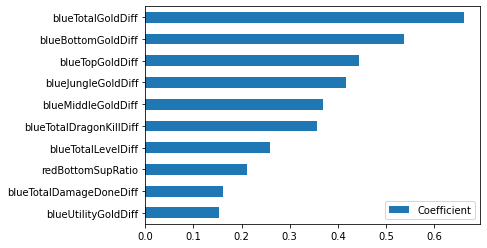

In [68]:
fi = {'Features':features, 'Coefficient':model.coef_[0]}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Coefficient', ascending=True)
importance.tail(10).plot(kind='barh');

위는 로지스틱 회귀 모델의 항목 별 회귀 계수가 가장 높은 항목 10개 이다. 

골드 관련 지표들이 회귀계수가 가장 높으며, 드래곤 및 레벨 등이 뒤를 잇고 있다.

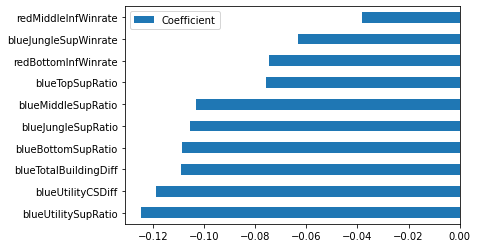

In [69]:
fi = {'Features':features, 'Coefficient':model.coef_[0]}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Coefficient', ascending=True)
importance.head(10).plot(kind='barh');

위는 계수가 음수인 항목들 중 절대값이 큰 10개 항목이다.

`SupRatio`는 해당 챔피언이 상대 동 포지션보다 15분 골드를 더 많이 벌 확률인데, 간단히게 표현하면 라인전을 이길 확률이다. 일반적으로 라인전이 약한 챔피언들은 성장 잠재력이 크다는 점이 반영되는 것 같다.

블루팀 서포터의 CS에서 레드팀 서포터의 CS를 뺀 값인 `blueUtilityCSDiff`의 계수가 음수인 점이 특이하다.

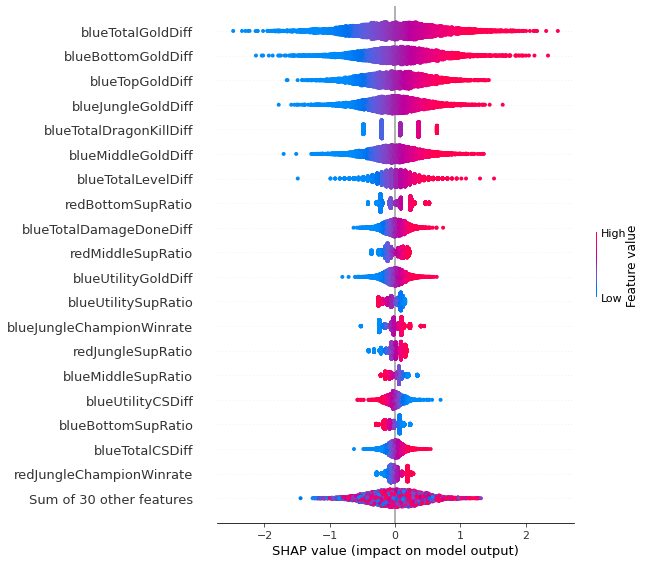

In [70]:
explainer = shap.LinearExplainer(model, X_test_selected)
shap_values = explainer(X_test_selected)

shap.plots.beeswarm(shap_values, max_display=20)

위 그래프는 항목이 예측에 영향을 미치는 정도를 나타낸다. 회귀계수와 마찬가지로 골드 관련 지표들이 전체적으로 영향력이 크다.

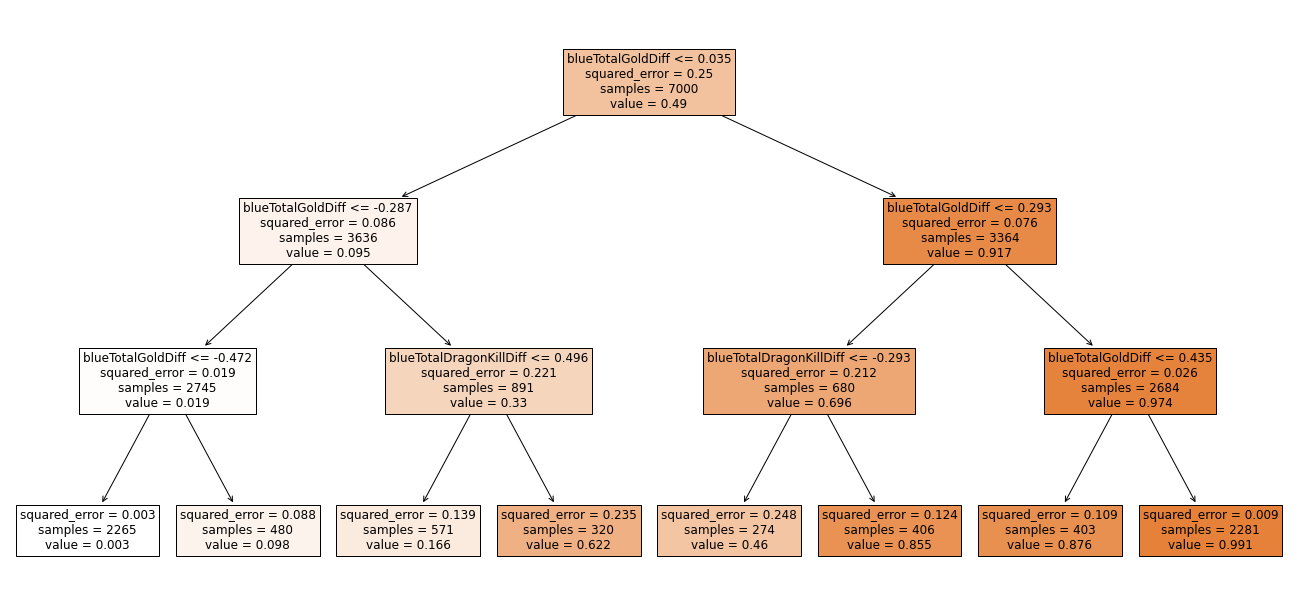

In [71]:
dt = DecisionTreeRegressor(random_state=0, max_depth=3)
dt.fit(X_test_selected, y_pred)

fig, ax = plt.subplots(figsize=(23, 11))
plot_tree(dt, feature_names=features, precision=3, 
           filled=True, fontsize=12, impurity=True);

다음은 Decision Tree를 이용해 모델이 데이터를 분류한 기준을 알아보았다. `blueTotalGoldDiff`(팀 골드 차이)를 가장 우선적으로 고려하며, 골드 차이가 일정 범위 내에 위치할 시, `blueTotalDragonKillDiff`(드래곤 처치 횟수 차이)를 고려한다.

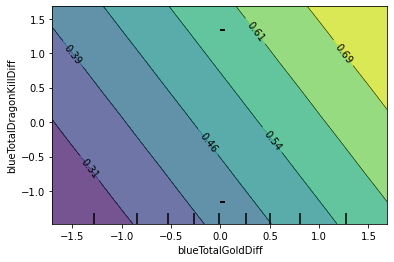

In [72]:
PartialDependenceDisplay.from_estimator(model, X_test_selected, [(0,5)]);

다음은 팀 골드 차이와 드래곤 처치 횟수 차이 간의 partial dependence plot 이다. 골드 획득량이 적어도 드래곤 처치 횟수가 많다면 이를 상쇄해주는 것을 확인할 수 있다.